# Predicting Metro Interstate Traffic Volume: A Multivariate Time Series Forecasting Approach with Vector Auto Regression 


### KJ MoChroi
**Department of Data Science, Bellevue University**  
**DSC680: Applied Data Science**  
**Dr. Brett Werner**  
**Spring 2023**  

**Change Control Log:**  

Change## : 1  
Change(s) Made:  Found and imported dataset
Date of Change:  4/15/2023    

Change## : 2  
Change(s) Made:  visualized dataset and inspected for missing values
Date of Change:  4/26/2023    

https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt 

In [2]:
df = pd.read_csv("Potential_Datasets/Metro_Interstate_Traffic_Volume.csv.gz", compression='gzip')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
# Let's make sure 'date' is actually a date in pandas
df["date_time"] = pd.to_datetime(df["date_time"])

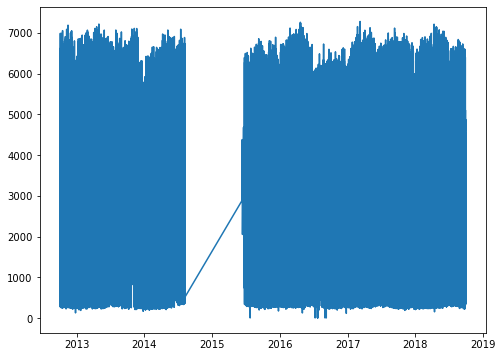

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df["date_time"], df["traffic_volume"]);

### Clean the dataset

In [5]:
# subset of dataframe
dates_2014_to_2015 = df[(df["date_time"] > '2014-07-01 09:00:00') & (df["date_time"] < '2015-07-01 09:00:00')]

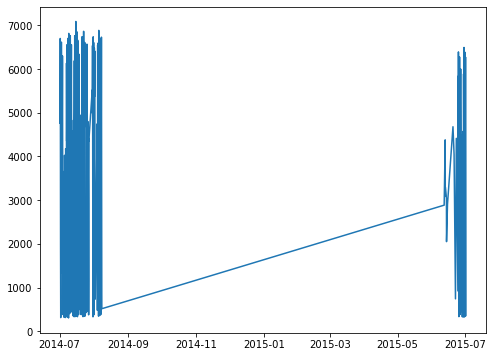

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(dates_2014_to_2015["date_time"], dates_2014_to_2015["traffic_volume"]);

In [7]:
# drop data prior to 2015 - 07  
df_complete = df[df["date_time"] > '2015-07-01 09:00:00']

- checking stationarity
- making non-stationary data stationary
- checking for feature correlation with target
- choosing appripriate train-test-split
- Creating the model
- Choosing validation metrics
 
https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/  

In [8]:
# one hot encoding categorical variables
df_encoded = pd.get_dummies(df_complete)

### Checking Stationarity with Augmented Dicky-Fuller Test

https://analyticsindiamag.com/complete-guide-to-dickey-fuller-test-in-time-series-analysis/

A key point to remember here is: Since the null hypothesis assumes the presence of a unit root, the p-value obtained by the test should be less than the significance level (say 0.05) to reject the null hypothesis. Thereby, inferring that the series is stationary.

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
target_df = df_complete[["date_time", "traffic_volume"]]
target_df.head()

,date_time,traffic_volume
16166,2015-07-01 10:00:00,4273
16167,2015-07-01 11:00:00,4469
16168,2015-07-01 12:00:00,4625
16169,2015-07-01 13:00:00,4462
16170,2015-07-01 14:00:00,4996


In [11]:
series = target_df["traffic_volume"].values

In [12]:
# ADF Test
result = adfuller(series, autolag='AIC')

In [13]:
# cite source here: https://analyticsindiamag.com/complete-guide-to-dickey-fuller-test-in-time-series-analysis/

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -21.926192
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject Ho - Time Series is Stationary


### Granger’s Causality Test 

In [14]:
from statsmodels.tsa.stattools import grangercausalitytests

In [15]:
column_names = df_encoded.columns.values.tolist()
column_names.remove('date_time')
column_names.remove('traffic_volume')

In [16]:
column_names

['temp',
 'rain_1h',
 'snow_1h',
 'clouds_all',
 'holiday_Christmas Day',
 'holiday_Columbus Day',
 'holiday_Independence Day',
 'holiday_Labor Day',
 'holiday_Martin Luther King Jr Day',
 'holiday_Memorial Day',
 'holiday_New Years Day',
 'holiday_None',
 'holiday_State Fair',
 'holiday_Thanksgiving Day',
 'holiday_Veterans Day',
 'holiday_Washingtons Birthday',
 'weather_main_Clear',
 'weather_main_Clouds',
 'weather_main_Drizzle',
 'weather_main_Fog',
 'weather_main_Haze',
 'weather_main_Mist',
 'weather_main_Rain',
 'weather_main_Smoke',
 'weather_main_Snow',
 'weather_main_Squall',
 'weather_main_Thunderstorm',
 'weather_description_SQUALLS',
 'weather_description_Sky is Clear',
 'weather_description_broken clouds',
 'weather_description_drizzle',
 'weather_description_few clouds',
 'weather_description_fog',
 'weather_description_freezing rain',
 'weather_description_haze',
 'weather_description_heavy intensity drizzle',
 'weather_description_heavy intensity rain',
 'weather_desc

In [ ]:
for name in column_names:
    print(name)
    grangercausalitytests(df_encoded[[name, 'traffic_volume']], maxlag=4)
    print('--------------------------------------')

*According to the results above, the columns with p values less than 0.05 should be included in the training model*

In [18]:
df_dropped = df_encoded[['date_time', 'temp', 'clouds_all', 'holiday_None', 'weather_main_Clear', 'weather_main_Clouds', 'weather_main_Fog', 'weather_main_Mist', 'weather_description_broken clouds', 'weather_description_few clouds', 'weather_description_fog', 'weather_description_light intensity drizzle', 'weather_description_mist', 'weather_description_overcast clouds', 'weather_description_scattered clouds', 'weather_description_sky is clear', 'weather_description_proximity shower rain', 'traffic_volume']]

In [19]:
df_dropped.head()

,date_time,temp,clouds_all,holiday_None,weather_main_Clear,weather_main_Clouds,weather_main_Fog,weather_main_Mist,weather_description_broken clouds,weather_description_few clouds,weather_description_fog,weather_description_light intensity drizzle,weather_description_mist,weather_description_overcast clouds,weather_description_scattered clouds,weather_description_sky is clear,weather_description_proximity shower rain,traffic_volume
16166,2015-07-01 10:00:00,289.24,40,1,0,1,0,0,0,0,0,0,0,0,1,0,0,4273
16167,2015-07-01 11:00:00,289.44,75,1,0,1,0,0,1,0,0,0,0,0,0,0,0,4469
16168,2015-07-01 12:00:00,290.53,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,4625
16169,2015-07-01 13:00:00,292.17,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,4462
16170,2015-07-01 14:00:00,293.61,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,4996


### Training and Validation Data Split

In [20]:
df_features = df_dropped.drop('date_time', axis = 1)

In [21]:
df_features.astype('int32').dtypes

temp                                           int32
clouds_all                                     int32
holiday_None                                   int32
weather_main_Clear                             int32
weather_main_Clouds                            int32
weather_main_Fog                               int32
weather_main_Mist                              int32
weather_description_broken clouds              int32
weather_description_few clouds                 int32
weather_description_fog                        int32
weather_description_light intensity drizzle    int32
weather_description_mist                       int32
weather_description_overcast clouds            int32
weather_description_scattered clouds           int32
weather_description_sky is clear               int32
weather_description_proximity shower rain      int32
traffic_volume                                 int32
dtype: object

In [22]:
df_datetime = df_dropped['date_time']

In [23]:
df_concat = pd.concat([df_datetime, df_features], axis=1)

In [24]:
df_final = df_concat.set_index('date_time') 

In [25]:
df_final.index = pd.DatetimeIndex(df_final.index).to_period('H')

In [26]:
df_final.dtypes

temp                                           float64
clouds_all                                       int64
holiday_None                                     uint8
weather_main_Clear                               uint8
weather_main_Clouds                              uint8
weather_main_Fog                                 uint8
weather_main_Mist                                uint8
weather_description_broken clouds                uint8
weather_description_few clouds                   uint8
weather_description_fog                          uint8
weather_description_light intensity drizzle      uint8
weather_description_mist                         uint8
weather_description_overcast clouds              uint8
weather_description_scattered clouds             uint8
weather_description_sky is clear                 uint8
weather_description_proximity shower rain        uint8
traffic_volume                                   int64
dtype: object

Lets choose 6 months of data for validation, and train the model on the other 2.5 years of data.

In [27]:
train = df_final[:int(0.8*(len(df_final)))]
valid = df_final[int(0.8*(len(df_final))):]
test_plot = df_datetime[int(0.8*(len(df_final))):]

### Train the Model

https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [28]:
# Import Statsmodels
from statsmodels.tsa.vector_ar.var_model import VAR

In [29]:
model = VAR(endog=train)

In [30]:
model_fit = model.fit()

In [31]:
prediction = model_fit.forecast(model_fit.endog, steps=len(valid))

In [32]:
cols = train.columns

In [33]:
from sklearn.metrics import mean_squared_error

In [34]:
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,17):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

In [35]:
pred.index = valid.index

In [36]:
pred

,temp,clouds_all,holiday_None,weather_main_Clear,weather_main_Clouds,weather_main_Fog,weather_main_Mist,weather_description_broken clouds,weather_description_few clouds,weather_description_fog,weather_description_light intensity drizzle,weather_description_mist,weather_description_overcast clouds,weather_description_scattered clouds,weather_description_sky is clear,weather_description_proximity shower rain,traffic_volume
date_time,,,,,,,,,,,,,,,,,
2018-02-24 08:00,256.086808,85.798617,0.997794,0.055161,0.01652,0.005471,0.298501,-0.007443,-0.012679,0.005471,0.050951,0.298501,0.061764,-0.025122,0.055493,0.002074,1990.58011
2018-02-24 08:00,256.040588,82.28748,0.997334,0.085165,0.036888,0.035657,0.274685,-0.0088,-0.018854,0.035657,0.047698,0.274685,0.096666,-0.032123,0.087491,0.000963,2155.301777
2018-02-24 08:00,256.026357,79.28077,0.99736,0.106321,0.057967,0.035452,0.274035,-0.005445,-0.02093,0.035452,0.043267,0.274035,0.115055,-0.030713,0.110554,0.000477,2309.606422
2018-02-24 08:00,256.037967,76.676979,0.997409,0.12495,0.077918,0.036204,0.263162,-0.000634,-0.020691,0.036204,0.04025,0.263162,0.125616,-0.026372,0.130816,0.000189,2452.364435
2018-02-24 09:00,256.071479,74.396979,0.997476,0.14221,0.095727,0.035562,0.253559,0.004305,-0.01934,0.035562,0.037519,0.253559,0.131994,-0.021232,0.149389,-0.000005,2583.424929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00,281.605124,47.932118,0.998516,0.304643,0.270037,0.020969,0.129299,0.072144,0.032497,0.020969,0.026266,0.129299,0.0907,0.074696,0.269318,0.003525,3251.488394
2018-09-30 20:00,281.605124,47.932118,0.998516,0.304643,0.270037,0.020969,0.129299,0.072144,0.032497,0.020969,0.026266,0.129299,0.0907,0.074696,0.269318,0.003525,3251.488394
2018-09-30 21:00,281.605124,47.932118,0.998516,0.304643,0.270037,0.020969,0.129299,0.072144,0.032497,0.020969,0.026266,0.129299,0.0907,0.074696,0.269318,0.003525,3251.488394


In [37]:
valid

,temp,clouds_all,holiday_None,weather_main_Clear,weather_main_Clouds,weather_main_Fog,weather_main_Mist,weather_description_broken clouds,weather_description_few clouds,weather_description_fog,weather_description_light intensity drizzle,weather_description_mist,weather_description_overcast clouds,weather_description_scattered clouds,weather_description_sky is clear,weather_description_proximity shower rain,traffic_volume
date_time,,,,,,,,,,,,,,,,,
2018-02-24 08:00,257.44,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,3018
2018-02-24 08:00,257.44,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,3018
2018-02-24 08:00,257.44,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3018
2018-02-24 08:00,257.44,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3018
2018-02-24 09:00,259.90,75,1,0,0,0,1,0,0,0,0,1,0,0,0,0,3753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00,283.45,75,1,0,1,0,0,1,0,0,0,0,0,0,0,0,3543
2018-09-30 20:00,282.76,90,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2781
2018-09-30 21:00,282.73,90,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2159


<AxesSubplot:xlabel='date_time'>

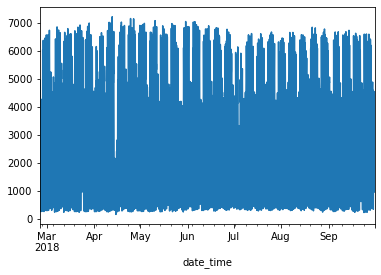

In [38]:
valid['traffic_volume'].plot()

<AxesSubplot:xlabel='date_time'>

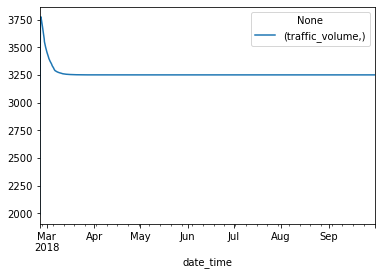

In [39]:
pred['traffic_volume'].plot()

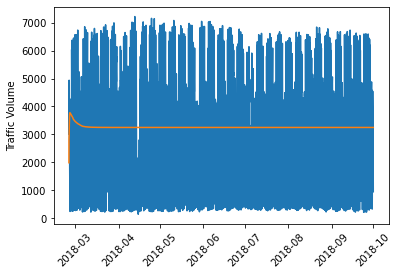

In [45]:
plt.plot(test_plot, valid['traffic_volume'])
plt.plot(test_plot, pred['traffic_volume'])
plt.xticks(rotation =45)
plt.ylabel('Traffic Volume')
plt.show()

In [41]:
#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])))

rmse value for temp is :  11.937561741919643
rmse value for clouds_all is :  39.32969146106891
rmse value for holiday_None is :  0.027931605625447536
rmse value for weather_main_Clear is :  0.44864794636650385
rmse value for weather_main_Clouds is :  0.43570137034247647
rmse value for weather_main_Fog is :  0.1526829275013179
rmse value for weather_main_Mist is :  0.3403281863381954
rmse value for weather_description_broken clouds is :  0.27779170903965306
rmse value for weather_description_few clouds is :  0.1704581822089871
rmse value for weather_description_fog is :  0.1526829275013179
rmse value for weather_description_light intensity drizzle is :  0.1656733528846707
rmse value for weather_description_mist is :  0.3403281863381954
rmse value for weather_description_overcast clouds is :  0.25323246886774164
rmse value for weather_description_scattered clouds is :  0.2591050202517264
rmse value for weather_description_sky is clear is :  0.4469846017480361
rmse value for weather_descr